# Phase 1: Exploratory Data Analysis (EDA) & Feature Engineering
**Project:** Nigerian-Context Fraud Detection System
**Goal:** Identify patterns in Nigerian financial transactions and engineer features that capture local fraud behaviors (USSD drains, midnight spikes, etc.).

### Objectives:
1. Load the synthetic Nigerian transaction data.
2. Analyze the distribution of fraud across different "Naira Bands."
3. Engineer 20+ features for our ML models.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.logger import get_logger
from pathlib import Path

# Initialize logger for the notebook
logger = get_logger("notebook_eda")

# Set visual style
plt.style.use('fivethirtyeight')
%matplotlib inline

# Load the data

filepath = Path("../../data/nigerian_transactions.csv").resolve()
df = pd.read_csv(filepath)
df['timestamp'] = pd.to_datetime(df['timestamp'])

logger.info("Data loaded and timestamp converted.")
df.head()

[2025-12-27 10:05:55] INFO [notebook_eda.<module>:22] Data loaded and timestamp converted.


,transaction_id,timestamp,sender_bank,amount,channel,location,device_type,is_fraud
0,TRX-1000000,2024-01-06 08:48:00,OPay,299301.54,Mobile App,Lagos,Feature Phone,0
1,TRX-1000001,2024-01-20 22:00:00,Moniepoint,5416.13,Web,Kano,Web,0
2,TRX-1000002,2024-01-20 01:07:00,Moniepoint,19560.98,POS,Enugu,Android,0
3,TRX-1000003,2024-01-28 03:57:00,Moniepoint,1017.63,USSD,Ibadan,Android,0
4,TRX-1000004,2024-01-07 16:01:00,OPay,19093.36,Mobile App,Abuja,Feature Phone,0


## 1. Contextual Analysis: The "Naira Band"
In the Nigerian ecosystem, fraud often follows specific amount patterns.
* **Micro-transactions:** Airtime/Data top-ups (Small amounts).
* **Target Bands:** ₦50,000 to ₦200,000 (Common daily limits/drain targets).


In [3]:
def engineer_initial_features(data):
    df_feat = data.copy()

    # 1. Temporal Features (WAT - West Africa Time)
    df_feat['hour'] = df_feat['timestamp'].dt.hour
    df_feat['day_of_week'] = df_feat['timestamp'].dt.dayofweek

    # Flag: Midnight transactions (12AM - 4AM) - High risk in Nigeria
    df_feat['is_midnight'] = df_feat['hour'].between(0, 4).astype(int)

    # 2. Amount Bands (Naira specific)
    df_feat['amount_band'] = pd.cut(
        df_feat['amount'],
        bins=[-np.inf, 5000, 50000, 200000, np.inf],
        labels=['micro', 'small', 'medium', 'high']
    )

    # 3. Channel Risk
    df_feat['is_ussd'] = (df_feat['channel'] == 'USSD').astype(int)

    logger.info("Initial features engineered: hour, day_of_week, is_midnight, amount_band, is_ussd")
    return df_feat


df_engineered = engineer_initial_features(df)
df_engineered.head()

[2025-12-27 10:06:09] INFO [notebook_eda.engineer_initial_features:21] Initial features engineered: hour, day_of_week, is_midnight, amount_band, is_ussd


,transaction_id,timestamp,sender_bank,amount,channel,location,device_type,is_fraud,hour,day_of_week,is_midnight,amount_band,is_ussd
0,TRX-1000000,2024-01-06 08:48:00,OPay,299301.54,Mobile App,Lagos,Feature Phone,0,8,5,0,high,0
1,TRX-1000001,2024-01-20 22:00:00,Moniepoint,5416.13,Web,Kano,Web,0,22,5,0,small,0
2,TRX-1000002,2024-01-20 01:07:00,Moniepoint,19560.98,POS,Enugu,Android,0,1,5,1,small,0
3,TRX-1000003,2024-01-28 03:57:00,Moniepoint,1017.63,USSD,Ibadan,Android,0,3,6,1,micro,1
4,TRX-1000004,2024-01-07 16:01:00,OPay,19093.36,Mobile App,Abuja,Feature Phone,0,16,6,0,small,0


## 2. Visualizing Fraud Distribution

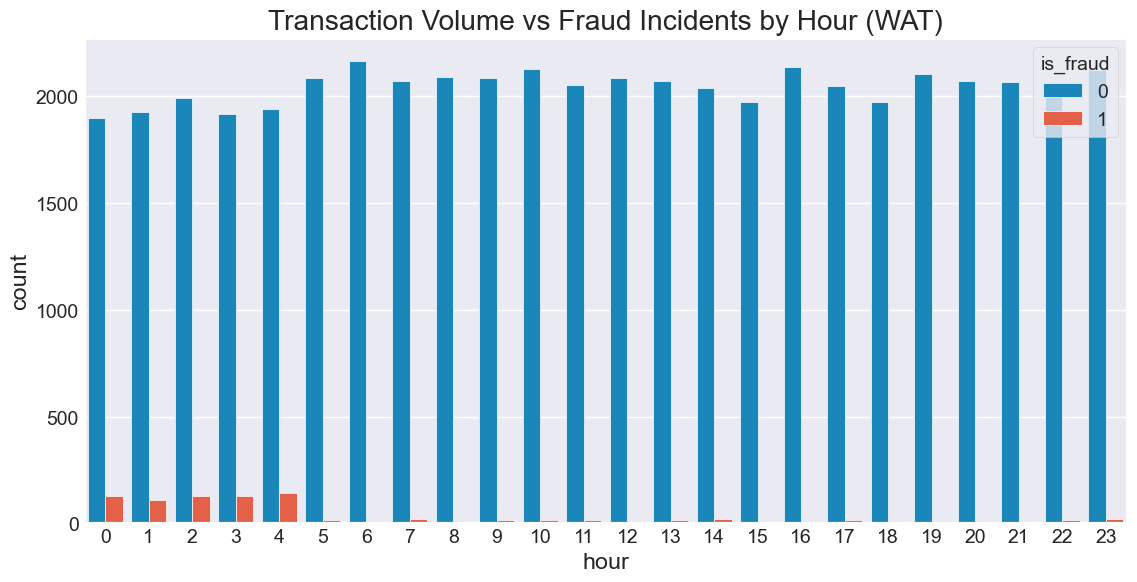

In [4]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_engineered, x='hour', hue='is_fraud')
plt.title('Transaction Volume vs Fraud Incidents by Hour (WAT)')
plt.show()

## 3. Advanced Feature Engineering: Transaction Velocity
Fraudsters often perform "Account Probing" or "Rapid Draining."
We will calculate:
* **Transaction Count (Last 24h):** Frequency of transactions from the same bank/location.
* **Amount Deviation:** Is this ₦200,000 transfer "normal" for this specific channel?

In [7]:
def engineer_velocity_features(data):
    df_v = data.copy()

    df_v['timestamp'] = pd.to_datetime(df_v['timestamp'])
    df_v = df_v.sort_values('timestamp')

    # Timestamp as index for rolling
    df_v = df_v.set_index('timestamp')

    # 1. Transaction count in last 24 hours
    tx_count_24h = (
        df_v
        .groupby(['sender_bank', 'location'])['amount']
        .rolling('24h')
        .count()
        .reset_index(level=[0, 1], drop=True)
    )

    df_v['tx_count_24h'] = tx_count_24h.values

    # 2. Total spend in last 24 hours
    total_spend_24h = (
        df_v
        .groupby(['sender_bank', 'location'])['amount']
        .rolling('24h')
        .sum()
        .reset_index(level=[0, 1], drop=True)
    )

    df_v['total_spend_24h'] = total_spend_24h.values

    # 3. Average transaction value deviation
    df_v['avg_tx_amount'] = (
        df_v.groupby('sender_bank')['amount'].transform('mean')
    )

    df_v['amount_vs_avg_ratio'] = (
        df_v['amount'] / df_v['avg_tx_amount']
    )

    # Restore timestamp column
    df_v = df_v.reset_index()

    logger.info(
        "Velocity features engineered: tx_count_24h, total_spend_24h, amount_vs_avg_ratio"
    )

    return df_v


df_final = engineer_velocity_features(df_engineered)

[2025-12-27 10:15:46] INFO [notebook_eda.engineer_velocity_features:44] Velocity features engineered: tx_count_24h, total_spend_24h, amount_vs_avg_ratio


### 1. Finalize the features Engineering

In [8]:

# 1. Drop columns
cols_to_drop = ['timestamp', 'transaction_id']
ml_ready_df = df_final.drop(columns=cols_to_drop)

# 2. Save as Parquet
file_output = '../../data/nigerian_fraud_features.parquet'
ml_ready_df.to_parquet(file_output, index=False)

logger.info(f"Feature Engineering Complete. Data saved to {file_output}")
ml_ready_df.head()

[2025-12-27 10:18:11] INFO [notebook_eda.<module>:9] Feature Engineering Complete. Data saved to ../../data/nigerian_fraud_features.parquet


,sender_bank,amount,channel,location,device_type,is_fraud,hour,day_of_week,is_midnight,amount_band,is_ussd,tx_count_24h,total_spend_24h,avg_tx_amount,amount_vs_avg_ratio
0,Zenith,346753.21,Mobile App,Abuja,Android,1,0,0,1,high,0,1.0,346400.40,64023.650647,5.416017
1,Zenith,6240.82,Web,Enugu,Android,0,0,0,1,small,0,2.0,440677.63,64023.650647,0.097477
2,Moniepoint,19985.38,Web,Abuja,Web,0,0,0,1,small,0,3.0,451415.91,62231.710709,0.321145
3,Access,14408.13,POS,Lagos,iPhone,0,0,0,1,small,0,4.0,581991.91,63670.987460,0.226290
4,Moniepoint,11807.47,Web,Port Harcourt,iPhone,0,0,0,1,small,0,5.0,590662.47,62231.710709,0.189734
